This notebook aims at evaluating 1 or 2 dimensional ranges on a SuMo built through Dakota.

In [1]:
import pathlib as pl
import shutil
import dakota.environment as dakenv
import sys, os
import numpy as np

# script_dir = pl.Path(__file__).parent
script_dir = pl.Path(os.getcwd())  ## how resilient is this?
print(script_dir)
sys.path.append(script_dir)

from utils import funs_create_dakota_conf, funs_data_processing

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation


## Load & process input data

In [2]:
TRAINING_SAMPLES_FILE = "train_Norm20D_1000LHS.dat"
tmp_folder = script_dir / ".tmp_output"
if tmp_folder.exists():
    shutil.rmtree(tmp_folder)
tmp_folder.mkdir()
TRAINING_SAMPLES_FILE = shutil.copy(TRAINING_SAMPLES_FILE, tmp_folder)
PROCESSED_TRAINING_FILE = funs_data_processing.process_input_file(TRAINING_SAMPLES_FILE)
variables_train = funs_data_processing.get_variable_names(PROCESSED_TRAINING_FILE)
print(variables_train)

['%eval_id', 'RELDEPTH', 'DIAMETER', 'ANGLE', 'ELECTRELDEPTH', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF', 'AFmax_4um', 'GAFmax_4um']


## Evaluate Dakota predictions

In [10]:
import pandas as pd
import copy
from create_20D_variables import VARIABLES_DF

INPUT_FILE = funs_data_processing.process_input_file(
    "sweep_Norm20DPos_AllVariables.dat",
    columns_to_remove=["interface", "POSITION", "AFmax_4um", "GAFmax_4um"],
)
INPUT_FILE = shutil.copy(INPUT_FILE, tmp_folder)

N_RESPONSES = 2

dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE,
    cross_validation_folds=None,
)
dakota_conf += funs_create_dakota_conf.add_evaluation_method(
    tmp_folder / INPUT_FILE, includes_eval_id=True
)
dakota_conf += funs_create_dakota_conf.add_variables(
    variables=variables_train[1:-N_RESPONSES],
)
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-N_RESPONSES:])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                ## hopefully faster by removing CV
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation/.tmp_output/train_Norm20D_1000LHS_processed.txt'
                    custom_annotated header eval_id
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method "EVALUATION"
            output debug
            model_pointer 'SURR_MODEL'
        
            list_parameter_study
                import_points_file 
                    ## this file should be wo responses!!
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation/.tmp

In [11]:
os.chdir(tmp_folder)
shutil.copy(script_dir / "execute_dakota.py", tmp_folder)
!python execute_dakota.py
os.chdir(script_dir)

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation/.tmp_output
Dakota version 6.19+ (stable) released Aug  8 2024.
Repository revision 494027b (2024-04-29) built Aug  8 2024 14:37:02.
Running serial Dakota executable in serial mode.
Start time: Tue Sep 17 13:37:07 2024

Using provided Dakota input string
Writing new restart file 'dakota.rst'.
Surrogate model retrieving points with 19 variables and 2 response
functions from file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/sumo_visual_evaluation/.tmp_output/train_Norm20D_1000LHS_processed.txt'
Variables read:
                      5.2840907790e-02 RELDEPTH
                      9.9312249720e-01 DIAMETER
                      6.3815589090e+00 ANGLE
                      5.9974290950e-01 ELECTRELDEPTH
                      5.1946396910e-01 THICKNESS_SKIN
                      1.5201558710e+00 THICKNESS_SCT
                      5.3197435840e-01 THICKNESS_APONEUROSIS
                   

In [63]:
N_EVALUATIONS = 11  ## n evaluations per variable
results = {"AFmax_4um": {}, "GAFmax_4um": {}}
variables_test = funs_data_processing.get_variable_names(
    "sweep_Norm20DPos_AllVariables.dat"
)[1:]
for RESPONSE in results.keys():
    y = funs_data_processing.get_results("sweep_Norm20DPos_AllVariables.dat", RESPONSE)
    y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", RESPONSE)
    if (tmp_folder / "variances.dat").is_file():
        std_hat = np.sqrt(
            funs_data_processing.get_results(
                tmp_folder / "variances.dat", RESPONSE + "_variance"
            )
        )

    # for i, variable in enumerate(variables_test):
    for i, variable in enumerate(variables_test[1:-N_RESPONSES]):
        if variable == "POSITION":
            results[RESPONSE][variable] = {
                "x": np.array([np.nan] * N_EVALUATIONS),
                "y": np.array([np.nan] * N_EVALUATIONS),
                "y_hat": np.array([np.nan] * N_EVALUATIONS),
                "std_hat": np.array([np.nan] * N_EVALUATIONS),
            }
        else:
            x = funs_data_processing.get_results(
                tmp_folder / "predictions.dat", variable
            )
            results[RESPONSE][variable] = {
                "x": x[i * N_EVALUATIONS : (i + 1) * N_EVALUATIONS],
                "y": y[i * N_EVALUATIONS : (i + 1) * N_EVALUATIONS],
                "y_hat": y_hat[i * N_EVALUATIONS : (i + 1) * N_EVALUATIONS],
                "std_hat": std_hat[i * N_EVALUATIONS : (i + 1) * N_EVALUATIONS],
            }

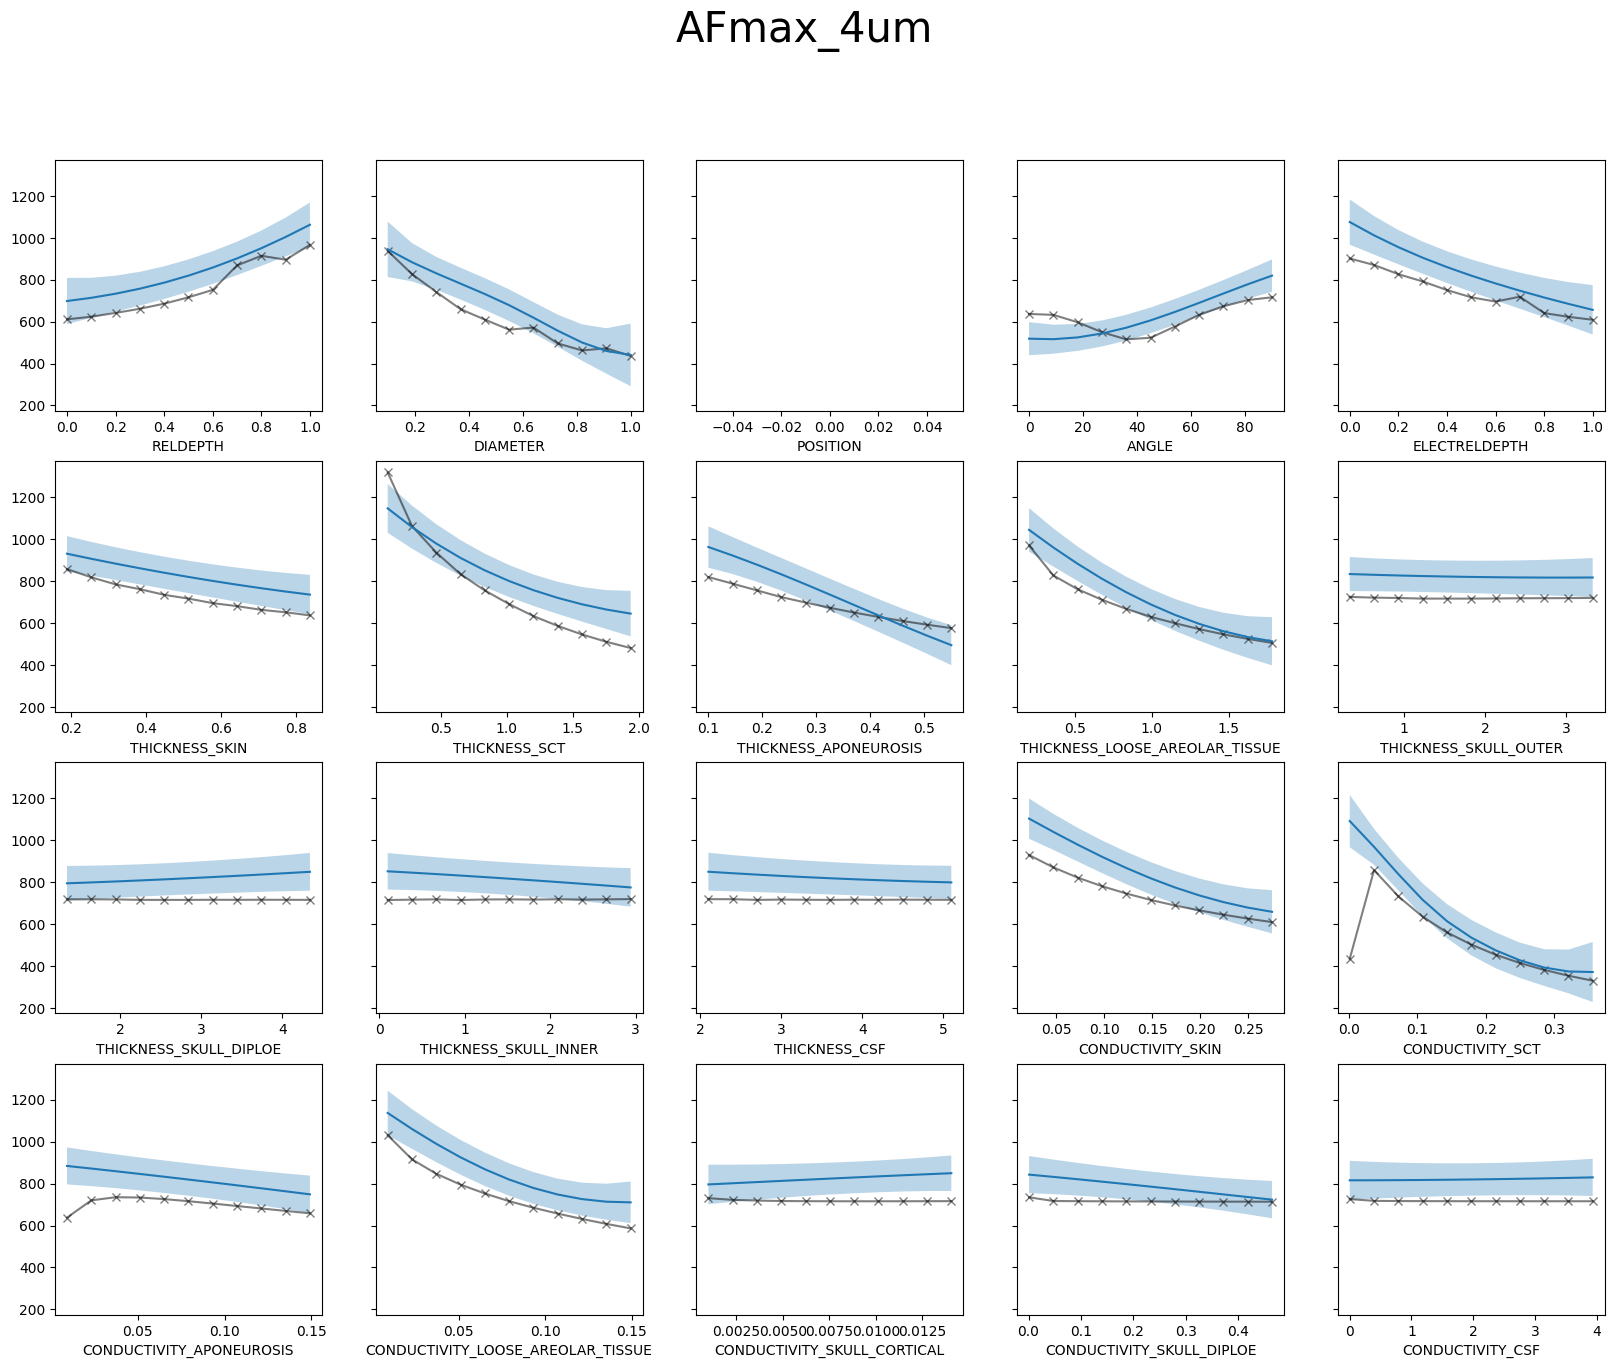

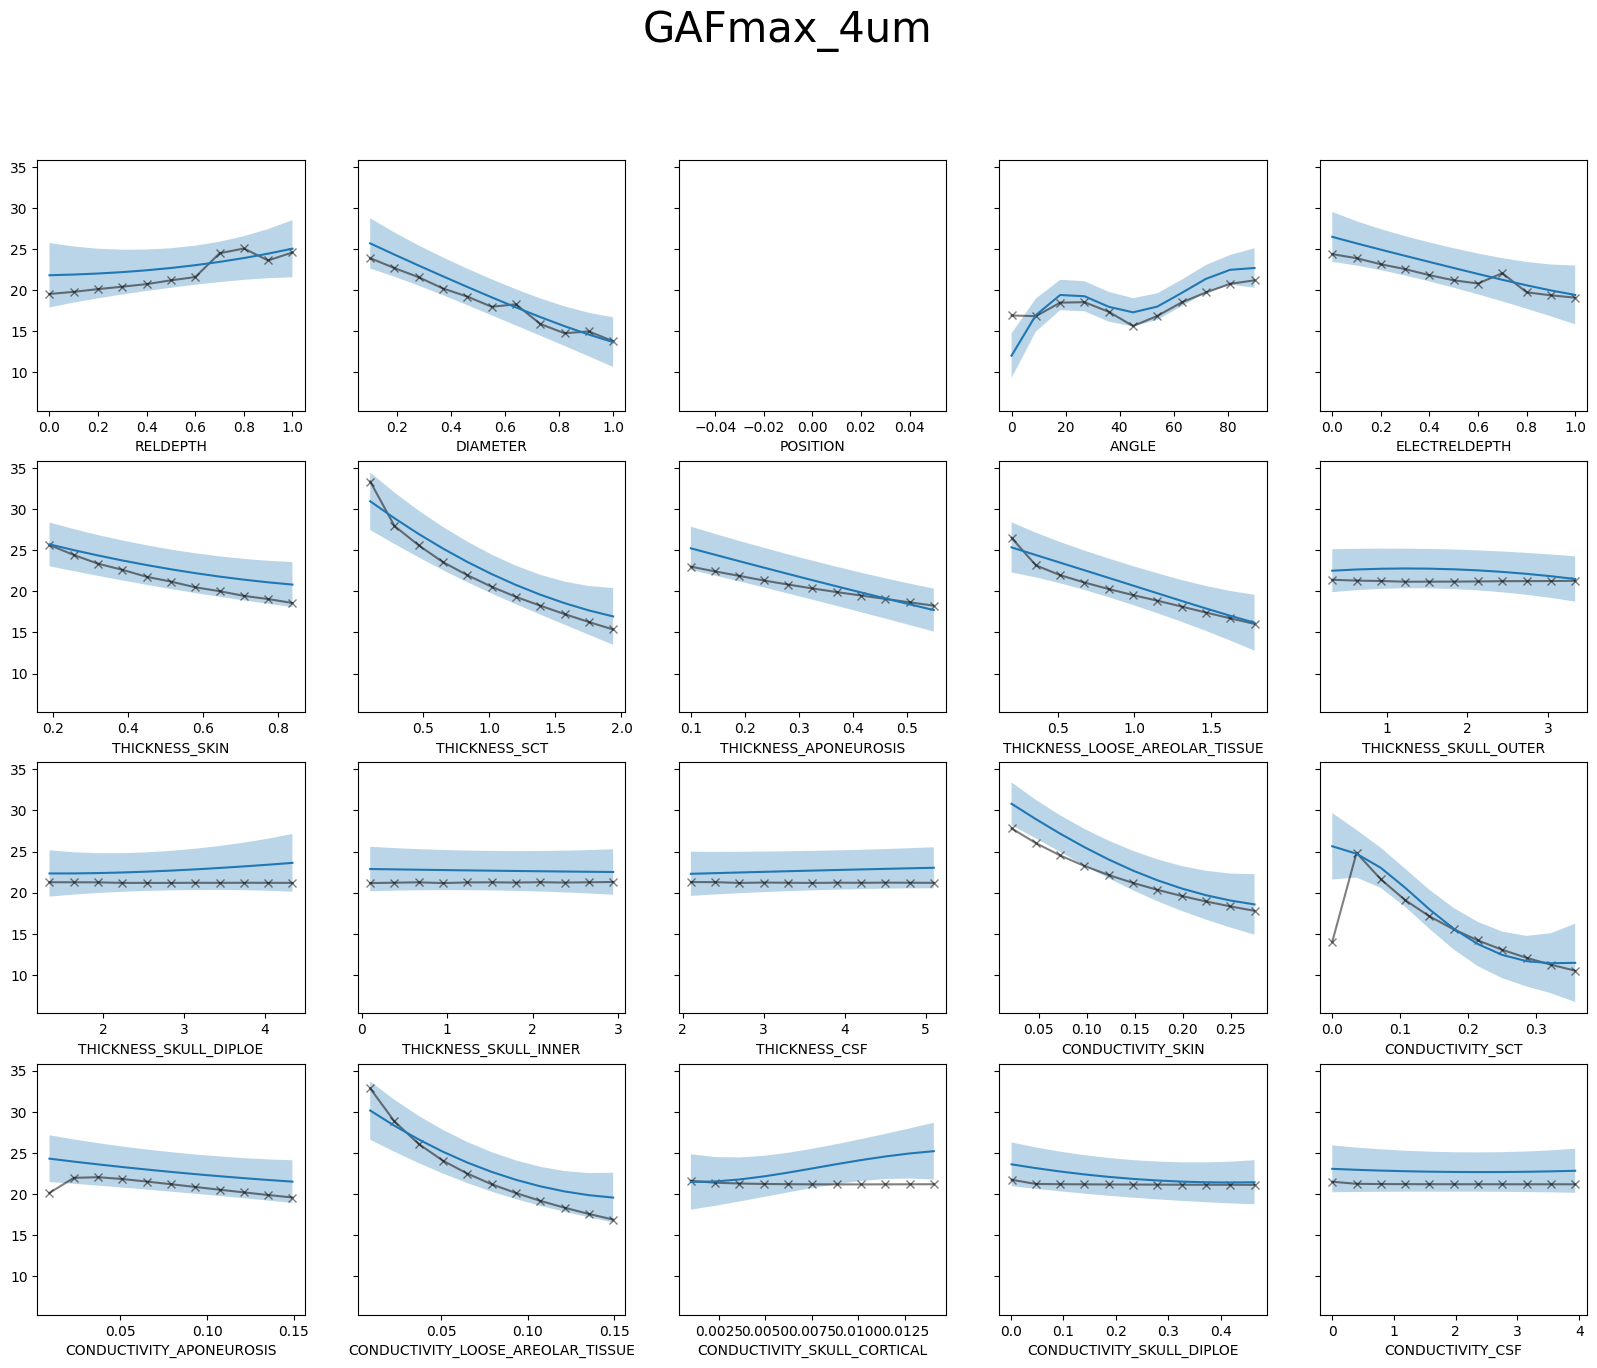

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

for RESPONSE, fulldata in results.items():
    fig, axs = plt.subplots(4, 5, figsize=(20, 15), sharey=True)
    axs: List[plt.Axes] = axs.flatten()

    for (variable, data), ax in zip(fulldata.items(), axs):
        ax.plot(data["x"], data["y"], "x-", color="k", alpha=0.5, label="True")
        ax.plot(data["x"], data["y_hat"], label="Predicted")
        ax.fill_between(
            data["x"],
            data["y_hat"] - 2 * data["std_hat"],
            data["y_hat"] + 2 * data["std_hat"],
            alpha=0.3,
        )
        ax.set_xlabel(variable)
    plt.suptitle(RESPONSE, fontsize=30)
    plt.show()

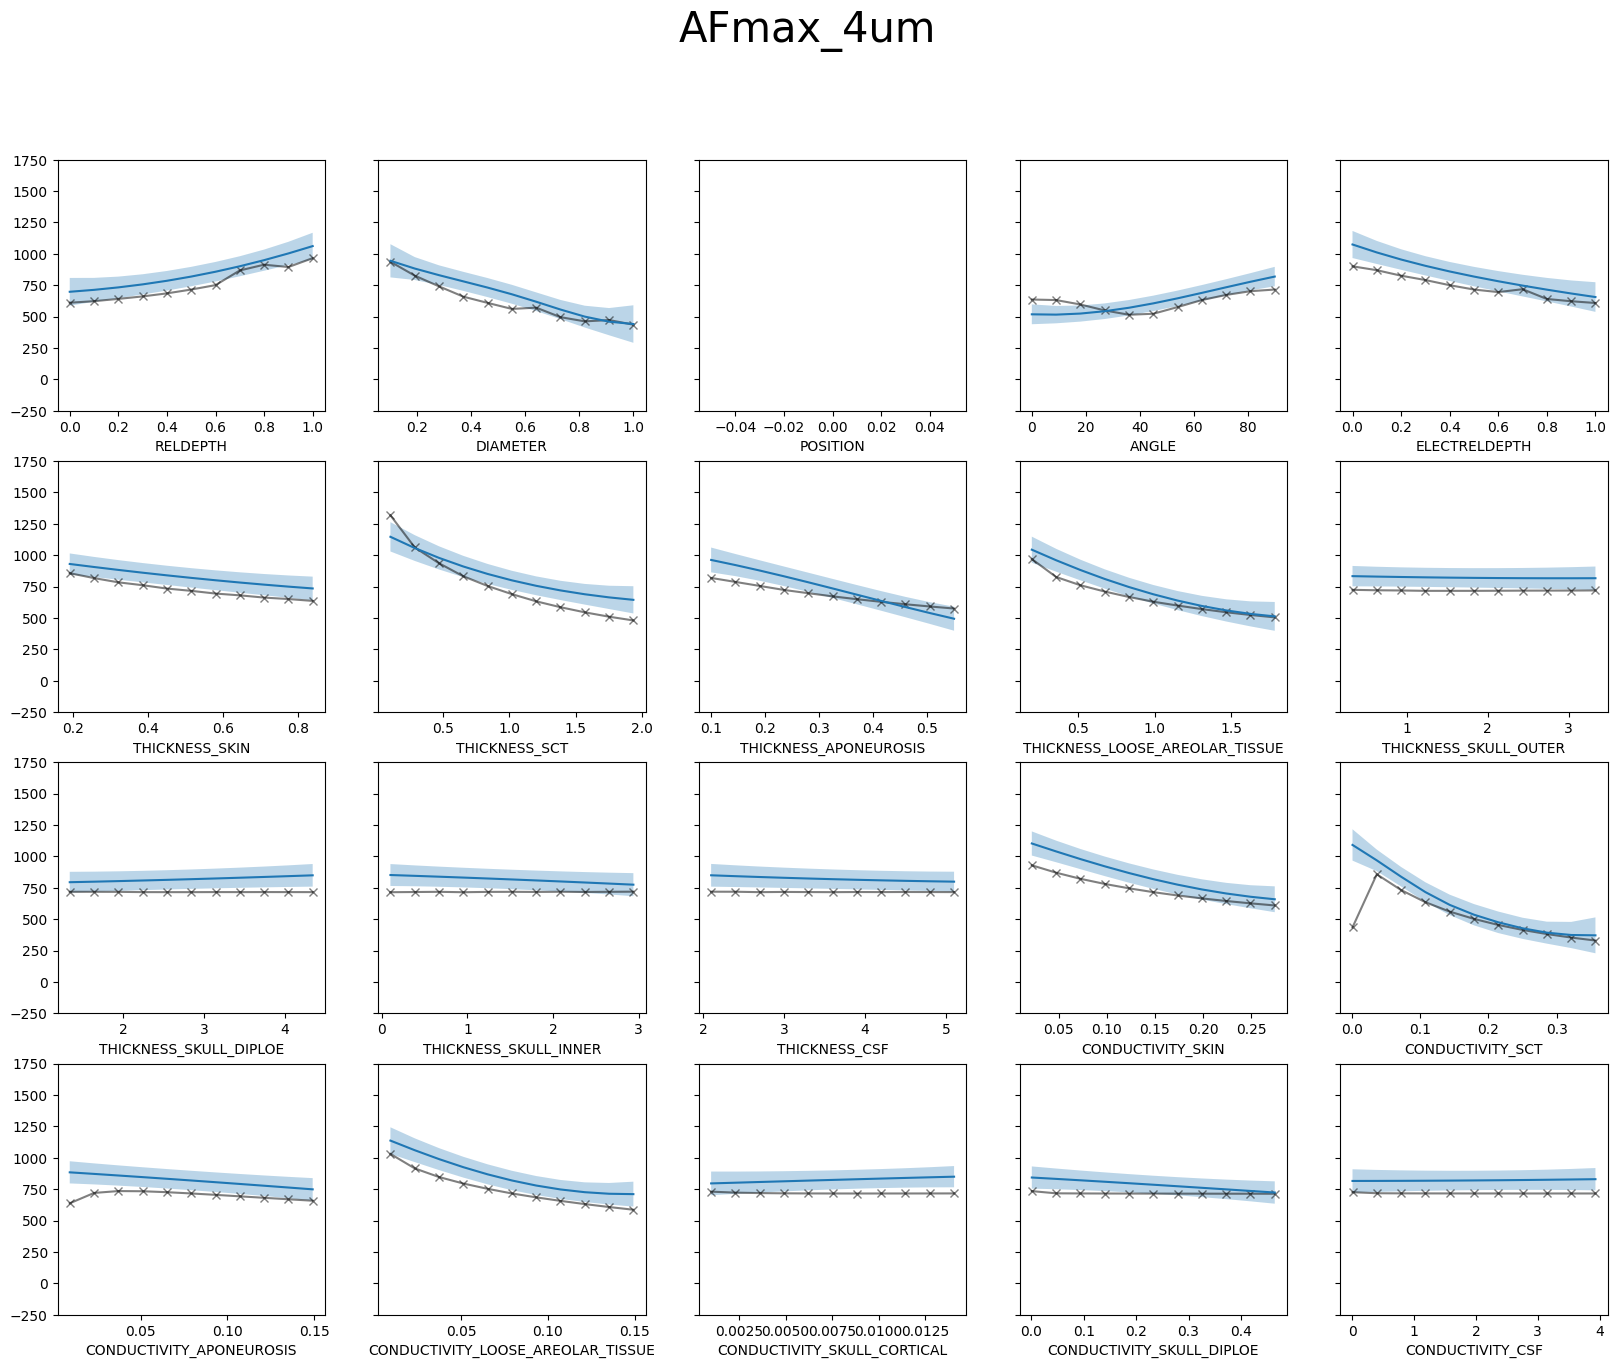

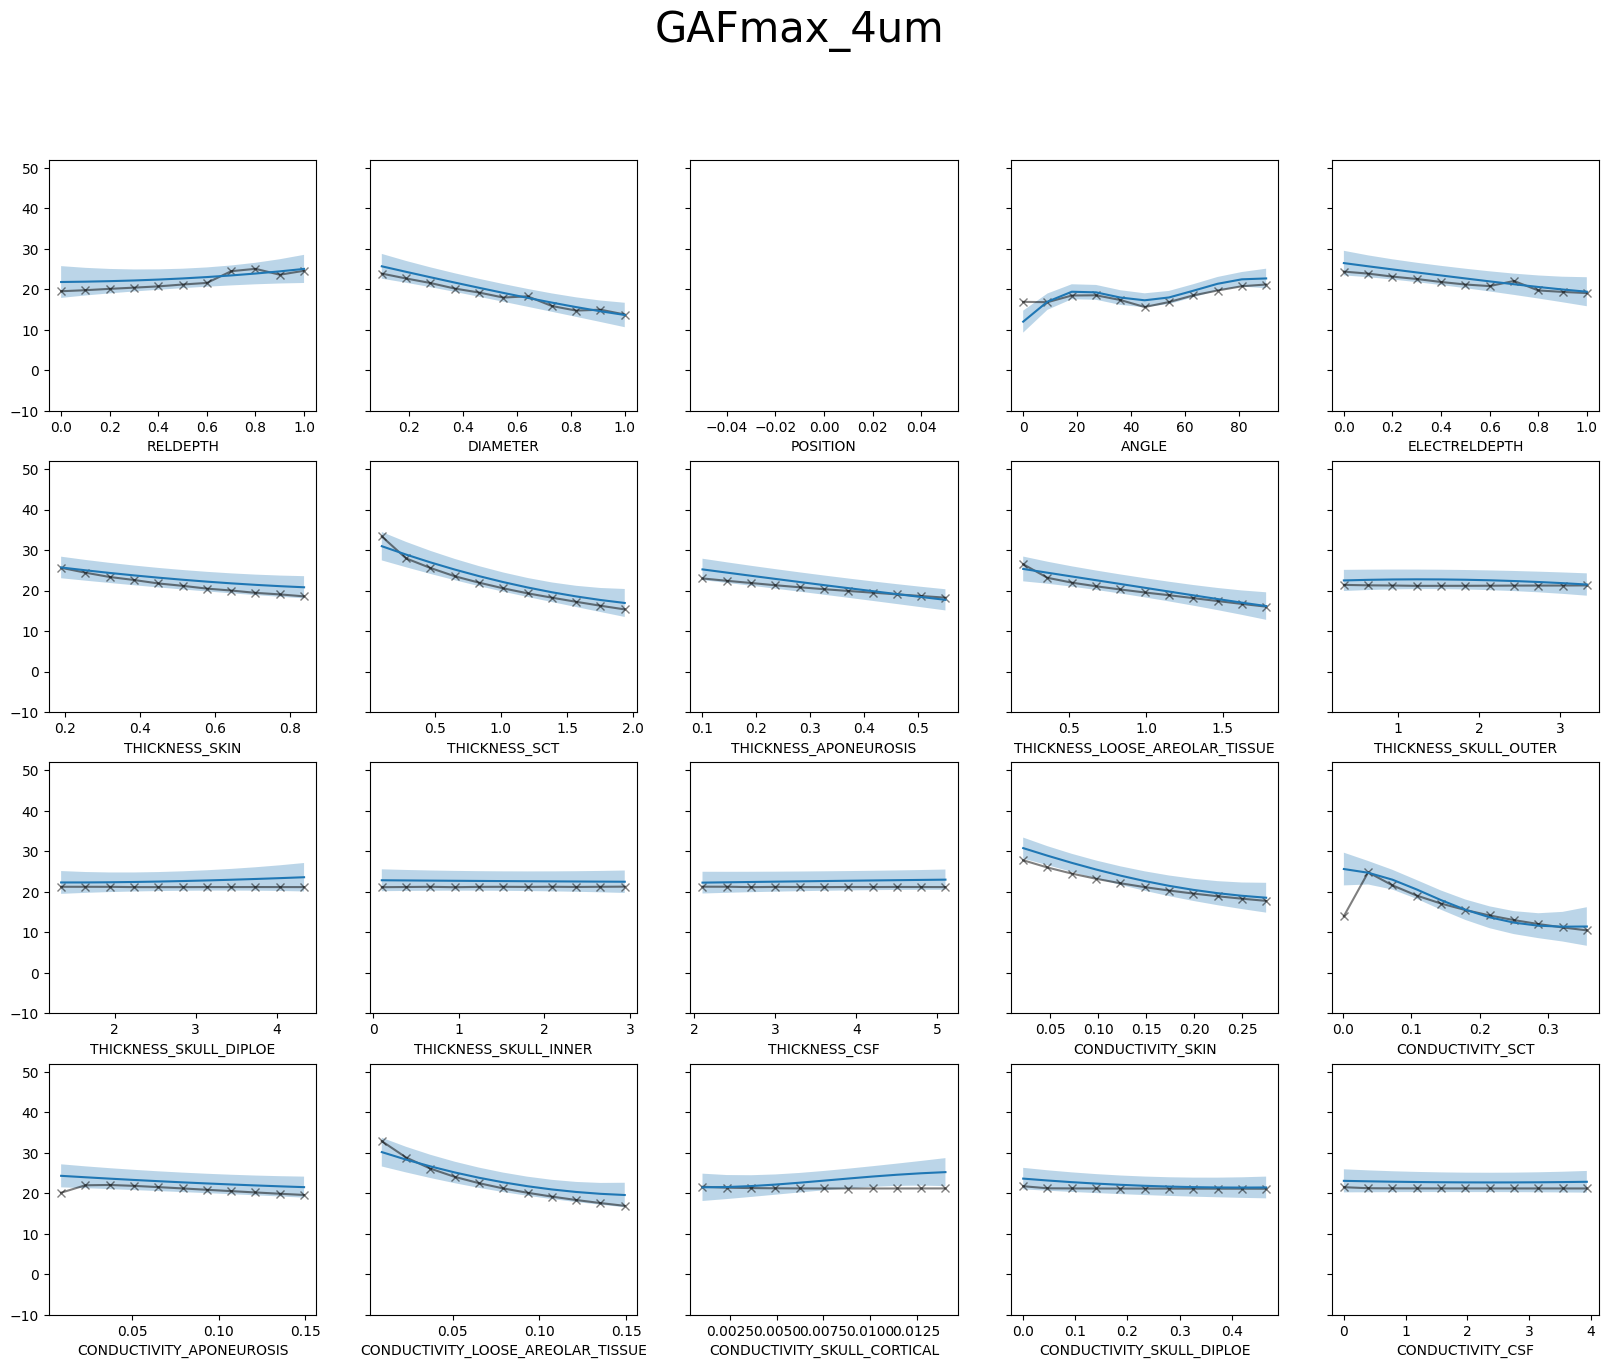

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

for RESPONSE, fulldata in results.items():
    fig, axs = plt.subplots(4, 5, figsize=(20, 15), sharey=True)
    axs: List[plt.Axes] = axs.flatten()

    for (variable, data), ax in zip(fulldata.items(), axs):
        ax.plot(data["x"], data["y"], "x-", color="k", alpha=0.5, label="True")
        ax.plot(data["x"], data["y_hat"], label="Predicted")
        ax.fill_between(
            data["x"],
            data["y_hat"] - 2 * data["std_hat"],
            data["y_hat"] + 2 * data["std_hat"],
            alpha=0.3,
        )
        ax.set_xlabel(variable)
    plt.suptitle(RESPONSE, fontsize=30)
    plt.ylim((-250, 1750) if RESPONSE == "AFmax_4um" else (-10, 52))
    plt.show()